# Simbot: Uncertainties

In this notebook, we will explore calibration of the robot's movement caused by imperfections in the robot, be they electronic, wheel alignement, friction, etc. 
No system is perfect in engineering, but control systems can help compensate for imperfections. Calibration is a low-level control system as it involves the following steps:

* Quantification of error in a systematic manner
* Development of a correction strategy
* Implementation of a correction strategy
* Operation of the corrected robot


## The Theory

The DDR library from the previous notebook allows to simulate the motion of a differential drive robot based on a set of parameters and commands prescribed by the user. The robot displacement is governed by exact equations of motion:
<br>
$$
\dot{x}=r\frac{\omega_R+\omega_L}{2}\cos{\alpha}
$$
<br>
$$
\dot{y}=r\frac{\omega_R+\omega_L}{2}\sin{\alpha}
$$
<br>
and
<br>
$$
\dot{\alpha}=\frac{r}{L}(\omega_R-\omega_L)
$$
<br>
The library does not solve these equations exactly, meaning in a continuous time, but in a <b>discrete</b> time. 

Even during a single user command, the equations are <b>discretized</b>:
$$
x(t+\Delta t) = x(t) +\Delta t\left(r\frac{\omega_R+\omega_L}{2}\cos{\alpha}\right),
$$
<br>

$$
y(t+\Delta t) = y(t) +\Delta t\left(r\frac{\omega_R+\omega_L}{2}\sin{\alpha}\right),
$$
<br>

$$
\alpha(t+\Delta t) = \alpha(t) +\Delta t\left(r\frac{\omega_R-\omega_L}{L}\right).
$$
according to a small time step $\Delta t$. This time step is only limited by the CPU performance (clock, RAM, number of inputs, etc). In the library below, $\Delta t$ is the variable 'self._delta'.

**Question: What is the smallest robot rotation your robot can execute for $\omega_R=-\omega_L=\omega$ and a given $\Delta t$**

**Answer:**

To simplify, assume the robot is moving straight along $x$. The displacement $\Delta x$ over one time step  $\Delta t$ is

$$
\Delta x = U\Delta t = \omega r \Delta t
$$

The robot is coded with a time step of $10^-2s$, therefore the smaller time increment is $\Delta x = 0.01U$. If $\omega = 10s^-1$ and $r=0.1m$, $\Delta x= 0.01m$.

For this choice of $\omega$ and $r$, the precision of the robot's motion cannot be smaller than $1cm$.



In [ ]:
"""Header cell, contains modules and functions to make the whole notebook experience better"""
%matplotlib inline 
# plots graphs within the notebook

from IPython.display import display,Image, Latex
from sympy.interactive import printing
printing.init_printing(use_latex='mathjax')
from IPython.display import clear_output

import time

from IPython.display import display,Image, Latex

from IPython.display import clear_output

import matplotlib.pyplot as plt
import numpy as np
import math
import scipy.constants as sc


def D2R(a):
    """function to convert degrees to radians. Takes single argument of degrees."""
    return float(((math.pi)*float(a))/180.0)
def R2D(a):
    """Function to convert radians to degrees. Takes single argument of radians."""
    return float((180.0*float(a)/(math.pi)))

    
font = {'family' : 'serif',
        #'color'  : 'black',
        'weight' : 'normal',
        'size'   : 12,
        }
fontlabel = {'family' : 'serif',
        #'color'  : 'black',
        'weight' : 'normal',
        'size'   : 12,
        }

from matplotlib.ticker import FormatStrFormatter
plt.rc('font', **font)


In [ ]:
import drivetrainbot as bot
import drivetrainbote as bote
import drivetrainbotee as botee


## Error quantification

We must first identify if there is an error: Let's try to move in a straight line, with a robot of class `bote`. Run the cell multiple times.

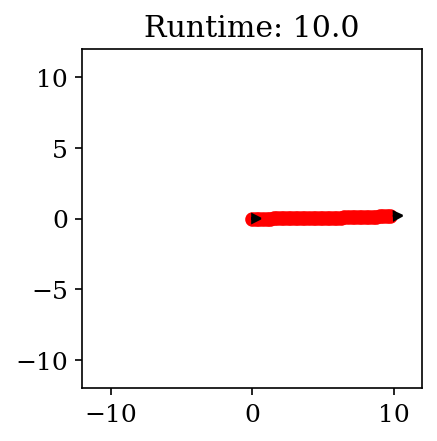

drift angle: 2.0909465071453215


In [ ]:
fig = plt.figure(figsize=(3,3),dpi=150)
ax = fig.add_subplot(111)
ax.set_aspect('equal')

# Your code here
mybot = bote.DDRobot()
mybot.plot = True             # turning on plot
mybot.mag_plot = 1.5          # coefficient of magnification of the arrow
mybot.step_plot = 25
mybot.length =0.4 #L
mybot.radius = 0.1 #r
mybot.plot_robot()            # plotting the robot!
om_rotation = 1
om_translation = 10
mybot.rt_spd_right = om_translation
mybot.rt_spd_left = om_translation
""" Checkpoint 0 (initial condition)"""
mybot.pos_x = 0 
mybot.pos_y = 0 
mybot.angle = 0

mybot.move(10)
    
mybot.plot_robot()            # plotting robot's movement 
plt.xlim([-12, 12])             # axis limits
plt.ylim([-12, 12])
plt.title("Runtime: %.1f" %mybot.runtime)
plt.show()                    # plotting full course of robots path

print("drift angle:",bote.R2D(mybot.angle))

## Derivation of a correction strategy

The first attempt at correcting the imperfection of our robot needs a framework of constraints and assumptions:

* The correction protocol should be automated, i.e. no user input.
* The drift is caused by one wheel only (randomly chosen).
* Each robot instance has its own random drift. 
* The angle of the robot with respect to the $x$-direction is an available variable, i.e. it is measured
* The measure of success should be demonstrated for several robots.

The proposed protocol is to derive the correction based on a simple test: Driving the robot in a straight line, over one given distance at different speeds. The drift is measured by the deviation of the `mybot.angle` at the end of the each run from 0. Running at different speeds should show if the robot's error is a function of the rotational speed.

As a first approach, assume that the error is on the left wheel in the form `mybot.rt_spd_right`$=\omega_L+\epsilon$, where $\omega_L=\omega_R=\omega$ for our protocol.

$$
\dot{x}=r\frac{\omega_R+(\omega_L+\epsilon)}{2}\cos{\alpha}
$$

$$
\dot{y}=r\frac{\omega_R+(\omega_L+\epsilon)}{2}\sin{\alpha}
$$

and

$$
\dot{\alpha}=\frac{r}{L}(\omega_R-(\omega_L+\epsilon))
$$


For a given angular speed $\omega$ and a given distance $X_0$, the duration of the robot's motion is

$$
T=\frac{X_0}{\omega r}
$$

where $r$ is the radius of the wheel. Regardless of the angular velocity, the ideal robot should end its travel at with $x(T)=X_0$, $y(T)=0$ and $\alpha(T)=0$.

With the error $\epsilon$, the angle drift can easily be integrated:


$$
\int_0^T\dot{\alpha}dt=\alpha(T)-\alpha(0)=\int_0^T \frac{r}{L}(\omega_R-(\omega_L+\epsilon))dt
$$

since $\omega_R,\omega_L,\epsilon$ are constant in time, the equation above is:

$$
\alpha(T)-\alpha(0)= \frac{r}{L}(\omega_R-(\omega_L+\epsilon))T
$$

With $\alpha=0$ and $\omega_L=\omega_R=\omega$, the error is

$$
\epsilon = -\frac{\alpha(T)L}{rT}
$$




# PB 0
A drivetrain robot turns left if $\omega_L = \omega -\epsilon$ and $\omega_R = \omega$ or $\omega_L = \omega$ and $\omega_R = \omega +\epsilon$ ($\epsilon>0$), the difference is in the radius of the turn $R$, which is easily derived from the figure below:

$$
R=\frac{L}{2}\frac{\omega_R+\omega_L}{\omega_R-\omega_L}
$$

<img src="drivetrainR.png" alt="Python Classes">

The following code illustrates the different trajectories for a perfect robot with $L=0.4$, $r=0.1$, $\omega = 10$ and $\epsilon = 1$. The robot moves for a time of $T=10s$.

* use the initial and final position of the robot to derive the radius of turn of both trajectory
* use the distance run by the robot to determine the halway angular speed 
$$\omega_\frac{1}{2}=\frac{\omega_R+\omega_L}{2}$$
and verify it matches the trajectories

R=0.00
omega_mid=0.00
R=0.00
omega_mid=0.00


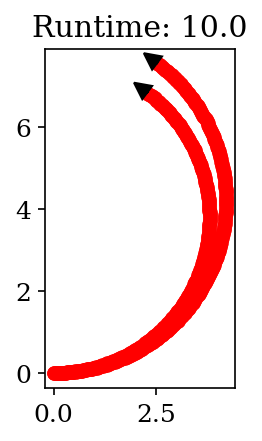

In [ ]:
T = 10
fig = plt.figure(figsize=(3,3),dpi=150)
ax = fig.add_subplot(111)
ax.set_aspect('equal')
mybot = bot.DDRobot()
mybot.plot = True
mybot.rt_spd_left = 10 - 1
mybot.rt_spd_right = 10
mybot.move(T)
""" Calculate and print radius of turn and midpoint angular velocity
here from mybot.pos_x and mybot.pos_y"""
print("R=%.2f"%0)
print("omega_mid=%.2f"%0)

mybot.plot_robot()
mybot.runtime = 0
mybot.pos_x = 0
mybot.pos_y = 0
mybot.angle = 0
mybot.rt_spd_left = 10
mybot.rt_spd_right = 10 + 1
mybot.move(T)
""" Calculate and print radius of turn and midpoint angular velocity
here from mybot.pos_x and mybot.pos_y"""
print("R=%.2f"%0)
print("omega_mid=%.2f"%0)

mybot.plot_robot()
# plt.xlim([-2, 102])             # axis limits
# plt.ylim([-2, 2])
plt.title("Runtime: %.1f" %mybot.runtime)
plt.show()

# PB 1

Expand the previous derivation to determine if the correction should be applied to the left or right wheel of a robot from class `bote`. Use and modify the following code

In [ ]:
mybot = bote.DDRobot()
mybot.plot = True
omega = np.array([1., 2.5, 5., 7.5, 10])

Tmove = 2 / (omega * mybot.radius)
print(Tmove)

[20.          8.          4.          2.66666667  2.        ]


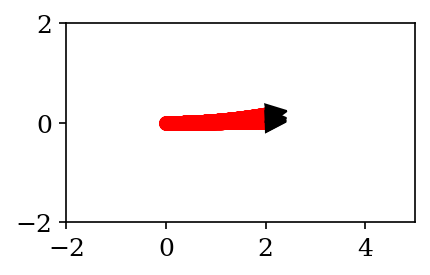

In [ ]:
angle_error = np.zeros_like(omega)

fig = plt.figure(figsize=(3,3),dpi=150)
ax = fig.add_subplot(111)
ax.set_aspect('equal')
for i in range(len(omega)):
    
    
    """ initial position"""
    mybot.pos_x = 0
    mybot.pos_y = 0
    mybot.angle = 0
    mybot.rt_spd_left = omega[i]
    mybot.rt_spd_right = omega[i]
    mybot.move(Tmove[i])
    mybot.plot_robot()
    angle_error[i] = mybot.angle
plt.xlim([-2, 5])             # axis limits
plt.ylim([-2, 2])
    # plt.title("Runtime: %.1f" %mybot.runtime)
plt.show()

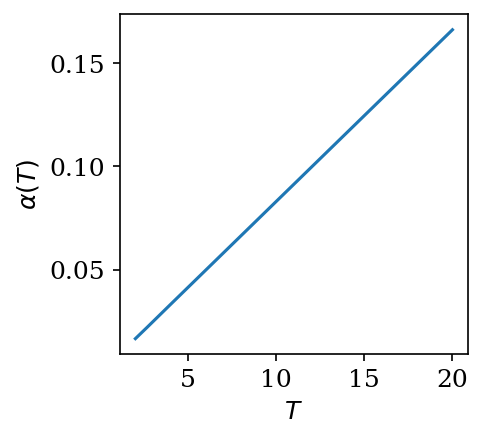

In [ ]:
fig = plt.figure(figsize=(3,3),dpi=150)
ax = fig.add_subplot(111)
plt.plot(Tmove,angle_error)
plt.xlabel(r"$T$")
plt.ylabel(r"$\alpha(T)$")
plt.show()

As expected from the above derivation, the final angle of the robot is a linear function of the time of motion, establishing that the error is not a function of $\omega$. The correction therefore is simply the addition or subtraction of an offset to one of the wheel.

**Your contribution is to derive an algorithm that identifies on which wheel the correction (see below) should be applied**

*Hint 1:* Consider that not only a corrected robot should move straight when asked to, it should cover the distance it is programmed to cover, regardless of its speed.

*Hint 2:* The calibration can be a two step process and can use both the final $x$ and $y$ position of the robot.

*Hint 3:* Why do you think you were asked to solve PB 0?

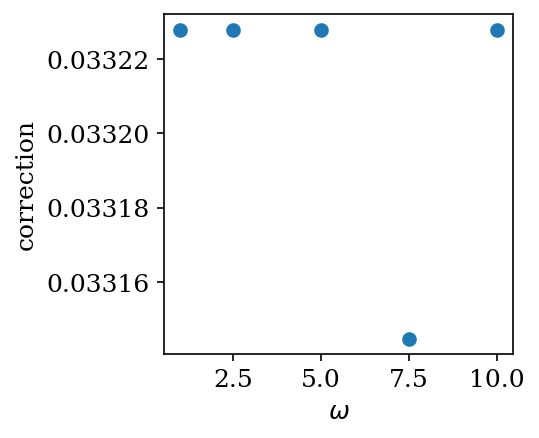

mean: 0.03321126016856047
median: 0.033227874105612974


In [ ]:

correction = angle_error/Tmove*mybot.length/mybot.radius
fig = plt.figure(figsize=(3,3),dpi=150)
ax = fig.add_subplot(111)
plt.plot(omega,correction,'o')
plt.xlabel(r"$\omega$")
plt.ylabel("correction")
plt.show()
print("mean:",np.mean(correction))
print("median:",np.median(correction))

### Correction

This is the cell you need to modify and run several times to make sure that your calibration is robust.


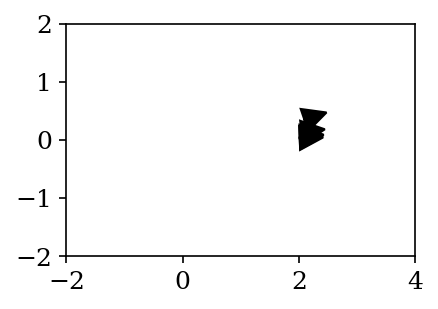

angle error: [0.32837044 0.13134818 0.06567409 0.04367327 0.03283704]
distance error: [0.09404745 0.04696532 0.02497505 0.01193715 0.01285391]


In [ ]:
mybot = bote.DDRobot()

""" Error quantification"""
angle_error = np.zeros_like(omega)
for i in range(len(omega)):
    
    
    """ initial position"""
    mybot.pos_x = 0
    mybot.pos_y = 0
    mybot.angle = 0
    mybot.rt_spd_left = omega[i]
    mybot.rt_spd_right = omega[i]
    mybot.move(Tmove[i])
    angle_error[i] = mybot.angle
""" Calculation of correction (choose mean or median)"""
# correction = np.mean(angle_error/Tmove*mybot.length/mybot.radius)
# correction = np.median(angle_error/Tmove*mybot.length/mybot.radius)

""" Calibration and Verfication """
angle_error = np.zeros_like(omega)
x_error = np.zeros_like(omega)

fig = plt.figure(figsize=(3,3),dpi=150)
ax = fig.add_subplot(111)
ax.set_aspect('equal')
for i in range(len(omega)):
    
    
    """ initial position"""
    mybot.pos_x = 0
    mybot.pos_y = 0
    mybot.angle = 0
    """ This is where you implement your correction algorithm """
    mybot.rt_spd_left = omega[i] + np.median(correction)
    mybot.rt_spd_right = omega[i]
    
    """ End of your modifications"""
    mybot.move(Tmove[i])
    mybot.plot_robot()
    angle_error[i] = mybot.angle
    x_error[i] = mybot.pos_x - 2
plt.xlim([-2, 4])             # axis limits
plt.ylim([-2, 2])
    # plt.title("Runtime: %.1f" %mybot.runtime)
plt.show()
print("angle error:",angle_error)
print("distance error:",x_error)

## Problem 2

Repeat the same operation with a robot of class `botee`. In this class, both wheels may be affected by errors



In [ ]:
""" Your code here """

## Problem 3

Using an uncorrected robot of class `botee`, devise an on-the-fly strategy based on the $y$ coordinate of the robot to travel from $(0,0)$ to $(100,\eta)$, $\Delta y\lesssim\eta\lesssim+\Delta y$, see below. **The instantaneous orientation of the robot `mybot.angle` is no longer accessible to you** (at least in theory for the purpose of this problem). **You can only use the $x$ coordinate to determine if you have reached the finish line at $x=100$.**

You will define a transversal distance $\Delta y$ in which you allow your robot to navigate. Once the `mybot.pos_y`$>\Delta y$ (`mybot.pos_y`$<-\Delta y$) you should correct the trajectory of the robot with a rotation. This assumes that you perform a series of small motions until your robot crosses the finish line. The pseudo code would look like this:
* While $x<X_{end}$
    * Move $T_{forward}$ with $\omega_R=\omega_L=\omega$
    * If $y>\Delta y$, correct orientation
    * Else if $y<-\Delta y$, correct orientation
    * repeat
You may want to think through what a good value for $T_{forward}$ might be as a function of $\omega r$.

In the absence of information on the orientation of the robot, I suggest an iterative method, outline here if $y>\Delta y$.
* store the current robot $y$ position 
* rotate robot clockwise over an angle of your choice
* move your robot forward over a small distance
* repeat until your new position $y$ is smaller than your old position 

In the end your trajectory should look like this:

<img src="example.png" alt="Python Classes">

In [ ]:
mybot = botee.DDRobot()

In [ ]:
fig = plt.figure(figsize=(6,3),dpi=150)
ax = fig.add_subplot(111)

pos_start = np.array([0.,0.])
pos_end = np.array([100.,0.])

mybot.plot = True

mybot.pos_x = pos_start[0]
mybot.pos_y = pos_start[1]
mybot.angle = 0

mybot.radius = 0.1
mybot.length = 0.4
mybot.mag_plot = 2.5          # coefficient of magnification of the arrow
mybot.step_plot = 30
""" angular speed for translation"""
omega = 10
""" angular speed and time for rotation"""
omega_rot = 5

"""distance from y=0 at which action to correct trajectory
should be taken"""
Deltay = 0.5 
""" Time increment between checking position y of the robot 
relative to +/- Deltay"""
DT = 0.1
alpha_rot = botee.D2R(20.)

""" niter and niter_max define a killswitch to avoid infinite loop"""
niter = 0
niter_max = 5000
T_to_Delta = 0
x_ref = pos_start[0]
y_ref = pos_start[1]

while (mybot.pos_x < pos_end[0]) and niter < niter_max:
    """ Your algorithm here"""
    
    mybot.rt_spd_left = mybot.rt_spd_right = omega
    mybot.move(DT)
    T_to_Delta += DT
    niter += 1

mybot.plot_robot()
plt.xlim([-2, 120])             # axis limits
# plt.ylim([-1, 1])
xplt = np.linspace(0,100,10)
plt.plot(xplt,+Deltay*np.ones_like(xplt),'b--')
plt.plot(xplt,-Deltay*np.ones_like(xplt),'b--')
plt.title("Runtime: %.1f" %mybot.runtime)
plt.text(105,Deltay,r"$+\Delta y$",color='b')
plt.text(105,-Deltay,r"$-\Delta y$",color='b')
# plt.yticks([])
# plt.savefig("myfig.png",bbox_inches="tight")
plt.show()